In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
import pyabc
import seaborn as sns

import healpy as hp
from scipy.special import sph_harm
import fitsio
import skyproj
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u

sys.path.insert(0, '/home/aew492/lss-dipoles/code')
import tools
import dipole
import multipoles
import generate_mocks as gm

In [3]:
plt.rcParams["font.family"] = "serif"

## quasar catalogs

In [4]:
blim = 30
nside_hi = 64
resdir = '/scratch/aew492/lss-dipoles_results/results'

In [5]:
# expected dipole direction
cmb_dipdir = dipole.cmb_dipole()[1]

In [6]:
# gather the number of (unmasked) sources in each sample (to overplot shot noise in excess power posterior)
Nsources = {}

#### Quaia

In [7]:
# selfunc
selfunc_quaia = gm.get_selfunc_map('quaia_G20.0_zodi', nside=nside_hi, blim=blim)
selfunc_quaia_orig = gm.get_selfunc_map('quaia_G20.0_orig', nside=nside_hi, blim=blim)

# load data
# masked
quaia_qmap = np.load(os.path.join(resdir, '../data/catalogs/quaia/quaia_G20.0_masked.npy'))
# the above map smoothed to 1sr
quaia_qmap_smoothed = np.load(os.path.join(resdir, '../data/catalogs/quaia/quaia_G20.0_masked_smoothed_1sr.npy'))
# correct by selfunc
quaia_qmap_corr = quaia_qmap / selfunc_quaia
# load the selfunc-corrected, smoothed map
quaia_qmap_corr_smoothed = np.load(os.path.join(resdir, '../data/catalogs/quaia/quaia_G20.0_masked_corr_smoothed_1sr.npy'))

# quaia_G20.0_orig
quaia_qmap_orig = quaia_qmap / selfunc_quaia_orig

# base rate for mocks
base_rate_quaia = 33.6330

# number of sources
Nsources['quaia_G20.0_zodi'] = int(np.nansum(quaia_qmap))
Nsources['quaia_G20.0_orig'] = int(np.nansum(quaia_qmap))

In [8]:
Nsources['quaia_G20.0_zodi']

509753

In [9]:
# hp.fit_dipole result
hp_dipole_quaia = hp.fit_dipole(quaia_qmap_corr)[1] / hp.fit_dipole(quaia_qmap_corr)[0]  # returns monopole and then 3 dipole components
dipamp, dipdir = dipole.get_dipole(hp_dipole_quaia)
dipamp, dipdir.galactic

(0.012918253969369827,
 <SkyCoord (Galactic): (l, b) in deg
     (303.15911297, 28.84933189)>)

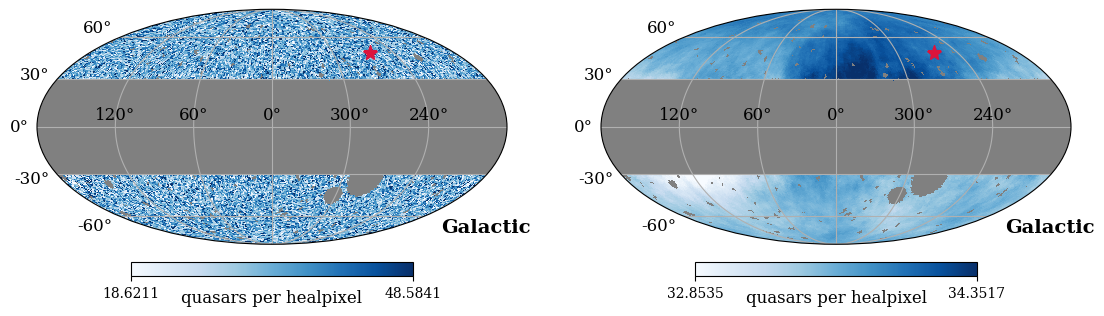

In [10]:
# plot
fig = plt.figure(figsize=(11,4))
kwargs = dict(coord=['C','G'], cmap=sns.color_palette("Blues", as_cmap=True),
              unit='quasars per healpixel', fig=fig, graticule=True, graticule_labels=True)#, badcolor='w')
mean, std = np.nanmean(quaia_qmap_corr), np.nanstd(quaia_qmap_corr)
hp.projview(quaia_qmap_corr, min=mean-2*std, max=mean+2*std, title='', sub=(1,2,1), **kwargs)
# tools.plot_marker(dipdir.galactic.l, dipdir.galactic.b, marker='*', color='white', mec='k', ms=12)
tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b, marker='*', color='crimson', ms=11)
tools.label_coord('Galactic', fs=14)
hp.projview(quaia_qmap_corr_smoothed, min=mean-0.1*std, max=mean+0.1*std, title='', sub=(1,2,2), **kwargs)
# tools.plot_marker(dipdir.galactic.l, dipdir.galactic.b, marker='*', color='white', mec='k', ms=12)
tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b, marker='*', color='crimson', ms=11)
tools.label_coord('Galactic', fs=14)

In [11]:
# Quaia G<20.5
selfunc_quaia_205 = gm.get_selfunc_map('quaia_G20.5_orig', nside=nside_hi, blim=blim)
# load catalog
qmap_raw = tools.load_catalog_as_map(f'../data/catalogs/quaia/quaia_G20.5.fits', frame='icrs', nside=nside_hi)
# mask
small_masks = fitsio.read(f'../data/masks/mask_master_hpx_r1.0.fits')
quaia_205 = qmap_raw * small_masks * tools.get_galactic_plane_mask(blim, nside=nside_hi, frame='icrs')
quaia_205[quaia_205 == 0.] = np.nan
# correct by selfunc
quaia_205_corr = quaia_205 / selfunc_quaia_205
# convert to overdensity map
odmap_quaia_205_corr = quaia_205_corr / np.nanmean(quaia_205_corr) - 1

# number of sources
Nsources['quaia_G20.5_orig'] = int(np.nansum(quaia_205))

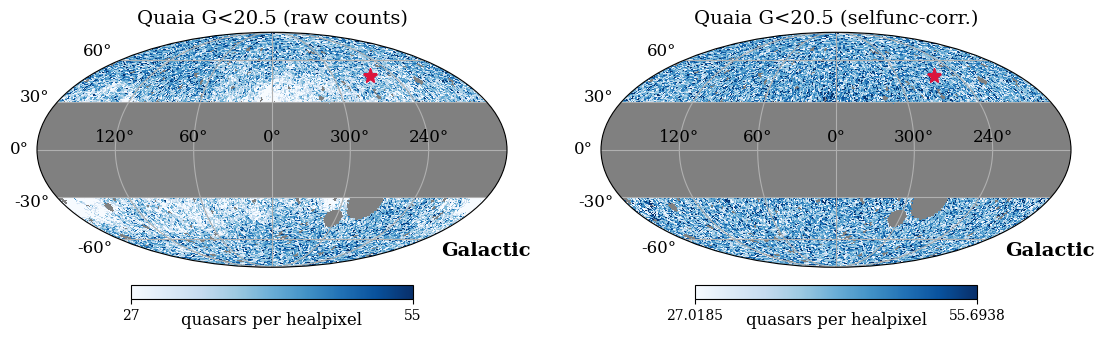

In [12]:
# plot
fig = plt.figure(figsize=(11,4))
kwargs = dict(coord=['C','G'], cmap=sns.color_palette("Blues", as_cmap=True),
              unit='quasars per healpixel', fig=fig, graticule=True, graticule_labels=True)#, badcolor='w')
mean, std = np.nanmean(quaia_205), np.nanstd(quaia_205)
hp.projview(quaia_205, min=27, max=55, title='Quaia G<20.5 (raw counts)', sub=(1,2,1), **kwargs)
# tools.plot_marker(dipdir.galactic.l, dipdir.galactic.b, marker='*', color='white', mec='k', ms=12)
tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b, marker='*', color='crimson', ms=11)
tools.label_coord('Galactic', fs=14)
mean, std = np.nanmean(quaia_205_corr), np.nanstd(quaia_205_corr)
hp.projview(quaia_205_corr, min=mean-2*std, max=mean+2*std, title='Quaia G<20.5 (selfunc-corr.)', sub=(1,2,2), **kwargs)
# tools.plot_marker(dipdir.galactic.l, dipdir.galactic.b, marker='*', color='white', mec='k', ms=12)
tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b, marker='*', color='crimson', ms=11)
tools.label_coord('Galactic', fs=14)

In [13]:
# Quaia G<20.0 zsplit2bin0
selfunc_quaia_zsplit2bin0 = gm.get_selfunc_map('quaia_G20.0_zsplit2bin0', nside=nside_hi, blim=blim)
# load catalog
qmap_raw = tools.load_catalog_as_map(f'../data/catalogs/quaia/quaia_G20.0_zsplit2bin0.fits', frame='icrs', nside=nside_hi)
# mask
small_masks = fitsio.read(f'../data/masks/mask_master_hpx_r1.0.fits')
quaia_zsplit2bin0 = qmap_raw * small_masks * tools.get_galactic_plane_mask(blim, nside=nside_hi, frame='icrs')
quaia_zsplit2bin0[quaia_zsplit2bin0 == 0.] = np.nan
# correct by selfunc
quaia_zsplit2bin0_corr = quaia_zsplit2bin0 / selfunc_quaia_zsplit2bin0
# convert to overdensity map
odmap_quaia_zsplit2bin0_corr = quaia_zsplit2bin0_corr / np.nanmean(quaia_zsplit2bin0_corr) - 1

# Quaia G<20.0 zsplit2bin1
selfunc_quaia_zsplit2bin1 = gm.get_selfunc_map('quaia_G20.0_zsplit2bin1', nside=nside_hi, blim=blim)
# load catalog
qmap_raw = tools.load_catalog_as_map(f'../data/catalogs/quaia/quaia_G20.0_zsplit2bin1.fits', frame='icrs', nside=nside_hi)
quaia_zsplit2bin1 = qmap_raw * small_masks * tools.get_galactic_plane_mask(blim, nside=nside_hi, frame='icrs')
quaia_zsplit2bin1[quaia_zsplit2bin1 == 0.] = np.nan
# correct by selfunc
quaia_zsplit2bin1_corr = quaia_zsplit2bin1 / selfunc_quaia_zsplit2bin1
# convert to overdensity map
odmap_quaia_zsplit2bin1_corr = quaia_zsplit2bin1_corr / np.nanmean(quaia_zsplit2bin1_corr) - 1

# number of sources
Nsources['quaia_G20.0_zsplit2bin0'] = int(np.nansum(quaia_zsplit2bin0))
Nsources['quaia_G20.0_zsplit2bin1'] = int(np.nansum(quaia_zsplit2bin1))

#### CatWISE

In [14]:
# selfunc
selfunc_catwise_elatcorr = gm.get_selfunc_map('catwise_elatcorr', nside=nside_hi, blim=blim)
selfunc_catwise_zodi = gm.get_selfunc_map('catwise_zodi', nside=nside_hi, blim=blim)
selfunc_catwise = gm.get_selfunc_map('catwise', nside=nside_hi, blim=blim)

# load data
# masked
catwise_qmap = np.load(os.path.join(resdir, '../data/catalogs/catwise_agns/catwise_agns_masked.npy'))
# the above map smoothed to 1sr
catwise_qmap_smoothed = np.load(os.path.join(resdir, '../data/catalogs/catwise_agns/catwise_agns_masked_smoothed_1sr.npy'))
# selfunc-corrected
catwise_qmap_corr_elatcorr = catwise_qmap / selfunc_catwise_elatcorr
catwise_qmap_corr_zodi = catwise_qmap / selfunc_catwise_zodi
# selfunc-corrected and smoothed
catwise_qmap_corr_elatcorr_smoothed = np.load(os.path.join(resdir, '../data/catalogs/catwise_agns/catwise_agns_masked_corr_elatcorr_smoothed_1sr.npy'))
catwise_qmap_corr_zodi_smoothed = np.load(os.path.join(resdir, '../data/catalogs/catwise_agns/catwise_agns_masked_corr_zodi_smoothed_1sr.npy'))

# base rate for mocks
base_rate_catwise = 77.4495

# number of sources
Nsources['catwise_zodi'] = int(np.nansum(catwise_qmap))
Nsources['catwise_elatcorr'] = int(np.nansum(catwise_qmap))
Nsources['catwise'] = int(np.nansum(catwise_qmap))

In [15]:
# hp.fit_dipole result with elatcorr (should match S21 result)
hp_dipole_catwise = hp.fit_dipole(catwise_qmap_corr_elatcorr)[1] / hp.fit_dipole(catwise_qmap_corr_elatcorr)[0]  # returns monopole and then 3 dipole components
dipamp, dipdir = dipole.get_dipole(hp_dipole_catwise)
dipamp, dipdir.galactic

(0.015334348323861371,
 <SkyCoord (Galactic): (l, b) in deg
     (237.73551446, 28.88093137)>)

In [16]:
# hp.fit_dipole result with selfunc including zodi
hp_dipole_catwise = hp.fit_dipole(catwise_qmap_corr_zodi)[1] / hp.fit_dipole(catwise_qmap_corr_zodi)[0]  # returns monopole and then 3 dipole components
dipamp, dipdir = dipole.get_dipole(hp_dipole_catwise)
dipamp, dipdir.galactic

(0.012374339860876405,
 <SkyCoord (Galactic): (l, b) in deg
     (191.77921627, 34.8197164)>)

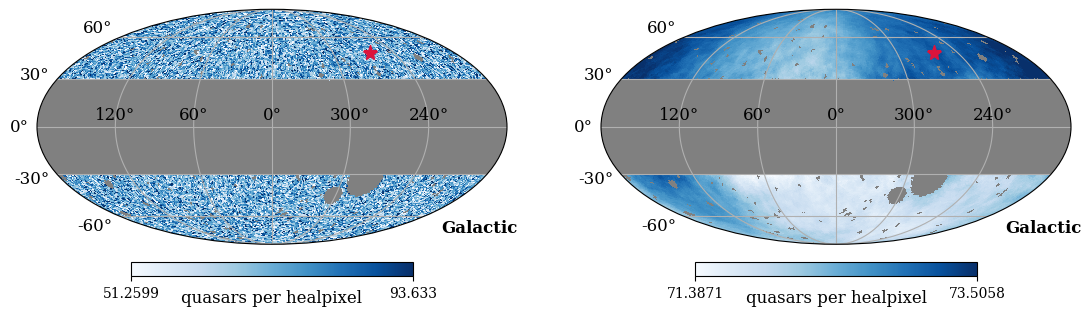

In [17]:
# plot
fig = plt.figure(figsize=(11,4))
kwargs = dict(coord=['C','G'], cmap=sns.color_palette("Blues", as_cmap=True),
              unit='quasars per healpixel', fig=fig, graticule=True, graticule_labels=True)#, badcolor='w')
mean, std = np.nanmean(catwise_qmap_corr_zodi), np.nanstd(catwise_qmap_corr_zodi)
hp.projview(catwise_qmap_corr_zodi, min=mean-2*std, max=mean+2*std, title='', sub=(1,2,1), **kwargs)
# tools.plot_marker(dipdir.galactic.l, dipdir.galactic.b, marker='*', color='white', mec='k', ms=12)
tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b, marker='*', color='crimson', ms=11)
tools.label_coord('Galactic', fs=12)
hp.projview(catwise_qmap_corr_zodi_smoothed, min=mean-0.1*std, max=mean+0.1*std, title='', sub=(1,2,2), **kwargs)
# tools.plot_marker(dipdir.galactic.l, dipdir.galactic.b, marker='*', color='white', mec='k', ms=12)
tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b, marker='*', color='crimson', ms=11)
tools.label_coord('Galactic', fs=12)

#### selection functions

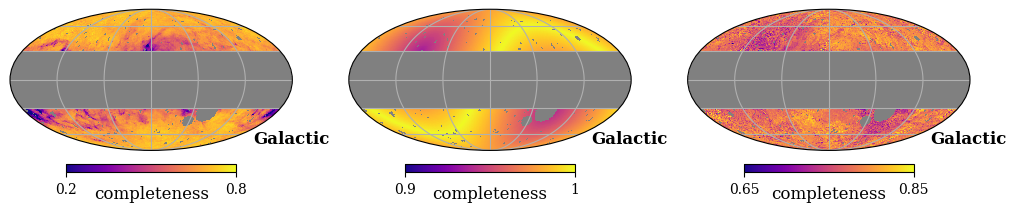

In [22]:
# plot
fig = plt.figure(figsize=(10,3))
kwargs = dict(coord=['C','G'], cmap='plasma', unit='completeness', fig=fig, graticule=True)#, badcolor='w')
selfunc_quaia_ = np.copy(selfunc_quaia)
selfunc_quaia_[selfunc_quaia <= 0.] = np.nan
selfunc_catwise_ = np.copy(selfunc_catwise_zodi)
selfunc_catwise_[selfunc_catwise_zodi <= 0.] = np.nan
selfunc_catwise_elatcorr_ = np.copy(selfunc_catwise_elatcorr)
selfunc_catwise_elatcorr_[selfunc_catwise_elatcorr_ <= 0.] = np.nan
hp.projview(selfunc_quaia_, title='', min=0.2, max=0.8, sub=(1,3,1), **kwargs)
tools.label_coord('Galactic', fs=12)
hp.projview(selfunc_catwise_elatcorr_, title='', min=0.9, max=1., sub=(1,3,2), **kwargs)
tools.label_coord('Galactic', fs=12)
hp.projview(selfunc_catwise_, title='', min=0.65, max=0.85, sub=(1,3,3), **kwargs)
tools.label_coord('Galactic', fs=12)

### dipole templates

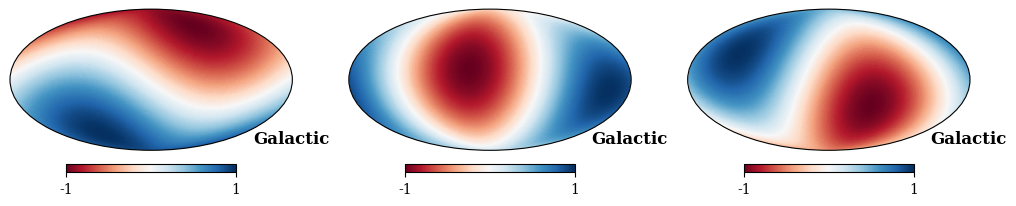

In [18]:
fig = plt.figure(figsize=(10,3))
comps = np.column_stack((np.zeros(3), np.diag([1, 1, 1])))
for i, comp in enumerate(comps):
    hp.projview(dipole.dipole_map(comp), coord=['C','G'], sub=(1, 3, i+1), cmap='RdBu', fig=fig, title='', min=-1, max=1)
    tools.label_coord('Galactic', fs=12)

### example mock generated from sky model

In [19]:
def case_dir(dipamp, log_excess, base_rate, selfunc_str, tag=''):
    return os.path.join(resdir, 'ABC/fake_data', f'dipole-{dipamp:.4f}_excess-1e{log_excess}_base-rate-{base_rate:.4f}{selfunc_str}{tag}')

In [20]:
input_dipamp = 0.0052
input_log_excess = -6.0
base_rate = 33.6330

nmocks = 500
ngens = 15

resdict = np.load(os.path.join(case_dir(input_dipamp, input_log_excess, base_rate, ''),
                               f'{nmocks}mocks_{ngens}gens_2025-03-03', 'results.npy'),
                  allow_pickle=True).item()
data = resdict['data']  # the data as raw quasar counts
selfunc = resdict['selfunc']
observation = resdict['observation']  # the data as overdensity
history = resdict['history']  # History object
prior = resdict['prior']  # dictionary
posterior = resdict['posterior']  # pandas dataframe and weights associated with the final posterior
old_posteriors = resdict['old_posteriors']  # posteriors from the otehr generations

In [21]:
# get the excess (all multipoles and dipole only) maps from the stored alms
excess_map = hp.sphtfunc.alm2map(data['alms'], 64)
excess_dipmap = hp.sphtfunc.alm2map(data['alms'][:3], 64)

# and the input kinematic dipole
cmb_dipdir = SkyCoord(264, 48, unit=u.deg, frame='galactic')
kinematic_comps = tools.spherical_to_cartesian(r=input_dipamp,
                                    theta=np.pi/2-cmb_dipdir.icrs.dec.rad,
                                    phi=cmb_dipdir.icrs.ra.rad)
kinematic_dipmap = dipole.dipole_map([0., *kinematic_comps])

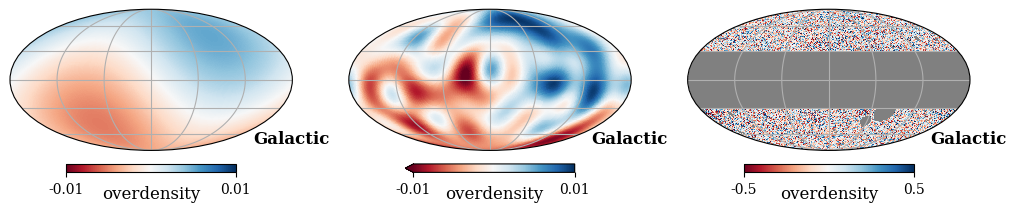

In [22]:
fig = plt.figure(figsize=(10,3))
kwargs = dict(coord=['C','G'], cmap='RdBu', unit='overdensity', fig=fig, title='', graticule=True) #, graticule_labels=True)
hp.projview(kinematic_dipmap, min=-0.01, max=0.01, sub=(1,3,1), **kwargs)
tools.label_coord('Galactic', fs=12)
hp.projview(excess_map + kinematic_dipmap, min=-0.01, max=0.01, sub=(1,3,2), **kwargs)
tools.label_coord('Galactic', fs=12)

datamap = data['data'].astype(float)
datamap[datamap == 0.] = np.nan
datamap_corr = datamap / selfunc
odmap_final = datamap_corr / np.nanmean(datamap_corr) - 1
hp.projview(odmap_final, min=-0.5, max=0.5, sub=(1,3,3), **kwargs)
tools.label_coord('Galactic', fs=12)

### "standard" dipole result (*note no regularization*)

In [18]:
# store results in a dictionary
labels = {
    'quaia_G20.0_zodi' : 'Quaia G20.0',
    'quaia_G20.0_orig' : 'Quaia G20.0 (no zodi)',
    'quaia_G20.5_orig' : 'Quaia G20.5 (no zodi)',
    'quaia_G20.0_zsplit2bin0' : 'Quaia G20.0 z<1.5',
    'quaia_G20.0_zsplit2bin1' : 'Quaia G20.0 z>1.5',
    'catwise_zodi' : 'CatWISE',
    'catwise_elatcorr' : 'S21',
    # 'catwise' : 'CatWISE (no zodi in SF)'
}  # keys are the sample names, values are the labels for plots and tables
standard_res = {
    'dipamps' : {},
    'dipdirs' : {},
    'relamps' : {}
}

#### Quaia

In [19]:
# hp.fit_dipole result
hp_dipole_quaia = hp.fit_dipole(quaia_qmap_corr)[1] / hp.fit_dipole(quaia_qmap_corr)[0]  # returns monopole and then 3 dipole components
dipamp, dipdir = dipole.get_dipole(hp_dipole_quaia)
dipamp, dipdir.galactic

(0.012918253969369827,
 <SkyCoord (Galactic): (l, b) in deg
     (303.15911297, 28.84933189)>)

In [20]:
# my function
# convert to overdensity map
odmap_quaia_corr = quaia_qmap_corr / np.nanmean(quaia_qmap_corr) - 1
odmap_quaia_orig = quaia_qmap_orig / np.nanmean(quaia_qmap_orig) - 1

# expected amplitude
quaia_expected_dipamp = 0.0052

# without weighting by selection function in fit (Cinv=identity) (this should match hp.fit_dipole)
dipamp1, dipdir1 = dipole.get_dipole(dipole.measure_overdensity_dipole_Lambda(odmap_quaia_corr, 0., selfunc=None))

# with the Quaia selection function as Cinv in the fit
dipamp2, dipdir2 = dipole.get_dipole(dipole.measure_overdensity_dipole_Lambda(odmap_quaia_corr, 0., selfunc=selfunc_quaia))
standard_res['dipamps']['quaia_G20.0_zodi'] = dipamp2
standard_res['dipdirs']['quaia_G20.0_zodi'] = dipdir2
standard_res['relamps']['quaia_G20.0_zodi'] = dipamp2 / quaia_expected_dipamp

# with Quaia G<20.0 orig
dipamp_orig, dipdir_orig = dipole.get_dipole(dipole.measure_overdensity_dipole_Lambda(odmap_quaia_orig, 0., selfunc=selfunc_quaia_orig))
standard_res['dipamps']['quaia_G20.0_orig'] = dipamp_orig
standard_res['dipdirs']['quaia_G20.0_orig'] = dipdir_orig
standard_res['relamps']['quaia_G20.0_orig'] = dipamp_orig / quaia_expected_dipamp

# with Quaia G<20.5
dipamp_205, dipdir_205 = dipole.get_dipole(dipole.measure_overdensity_dipole_Lambda(odmap_quaia_205_corr, 0., selfunc=selfunc_quaia_205))
standard_res['dipamps']['quaia_G20.5_orig'] = dipamp_205
standard_res['dipdirs']['quaia_G20.5_orig'] = dipdir_205
standard_res['relamps']['quaia_G20.5_orig'] = dipamp_205 / quaia_expected_dipamp

# zsplits
dipamp_bin0, dipdir_bin0 = dipole.get_dipole(dipole.measure_overdensity_dipole_Lambda(odmap_quaia_zsplit2bin0_corr, 0.,
                                                                                      selfunc=selfunc_quaia_zsplit2bin0))
dirstr_zsplit2bin0 = f"({dipdir_bin0.galactic.l.deg:.1f}, {dipdir_bin0.galactic.b.deg:.1f})"
standard_res['dipamps']['quaia_G20.0_zsplit2bin0'] = dipamp_bin0
standard_res['dipdirs']['quaia_G20.0_zsplit2bin0'] = dipdir_bin0
standard_res['relamps']['quaia_G20.0_zsplit2bin0'] = dipamp_bin0 / quaia_expected_dipamp

dipamp_bin1, dipdir_bin1 = dipole.get_dipole(dipole.measure_overdensity_dipole_Lambda(odmap_quaia_zsplit2bin1_corr, 0.,
                                                                                      selfunc=selfunc_quaia_zsplit2bin1))
standard_res['dipamps']['quaia_G20.0_zsplit2bin1'] = dipamp_bin1
standard_res['dipdirs']['quaia_G20.0_zsplit2bin1'] = dipdir_bin1
standard_res['relamps']['quaia_G20.0_zsplit2bin1'] = dipamp_bin1 / quaia_expected_dipamp

#### CatWISE

In [21]:
# hp.fit_dipole result (*we expect this to be the S21 result, since we've corrected with 'elatcorr' selfunc*)
hp_dipole_catwise = hp.fit_dipole(catwise_qmap_corr_elatcorr)[1] / hp.fit_dipole(catwise_qmap_corr_elatcorr)[0]  # returns monopole and then 3 dipole components
dipamp, dipdir = dipole.get_dipole(hp_dipole_catwise)
dipamp, dipdir.galactic

(0.015334348323861371,
 <SkyCoord (Galactic): (l, b) in deg
     (237.73551446, 28.88093137)>)

In [22]:
# load relevant selfuncs
selfunc_catwise = gm.get_selfunc_map('catwise', nside=nside_hi, blim=blim)
selfunc_catwise_zodi = gm.get_selfunc_map('catwise_zodi', nside=nside_hi, blim=blim)
selfunc_catwise_elatcorr = gm.get_selfunc_map('catwise_elatcorr', nside=nside_hi, blim=blim)

# expected amplitude
catwise_expected_dipamp = 0.0074

# construct overdensity maps
catwise_zodi_qmap_corr = catwise_qmap / selfunc_catwise_zodi
catwise_elatcorr_qmap_corr = catwise_qmap / selfunc_catwise_elatcorr
catwise_qmap_corr = catwise_qmap / selfunc_catwise
odmap_catwise_zodi = catwise_zodi_qmap_corr / np.nanmean(catwise_zodi_qmap_corr) - 1
odmap_catwise_elatcorr = catwise_elatcorr_qmap_corr / np.nanmean(catwise_elatcorr_qmap_corr) - 1
odmap_catwise = catwise_qmap_corr / np.nanmean(catwise_qmap_corr) - 1

# CatWISE with zodi
dipamp_catwise_zodi, dipdir_catwise_zodi = dipole.get_dipole(dipole.measure_overdensity_dipole_Lambda(odmap_catwise_zodi,
                                                                                                      0.,
                                                                                                      selfunc=selfunc_catwise_zodi))
standard_res['dipamps']['catwise_zodi'] = dipamp_catwise_zodi
standard_res['dipdirs']['catwise_zodi'] = dipdir_catwise_zodi
standard_res['relamps']['catwise_zodi'] = dipamp_catwise_zodi / catwise_expected_dipamp

# CatWISE with elatcorr
dipamp_catwise_elatcorr, dipdir_catwise_elatcorr = dipole.get_dipole(dipole.measure_overdensity_dipole_Lambda(odmap_catwise_elatcorr,
                                                                                                      0.,
                                                                                                      selfunc=selfunc_catwise_elatcorr))
standard_res['dipamps']['catwise_elatcorr'] = dipamp_catwise_elatcorr
standard_res['dipdirs']['catwise_elatcorr'] = dipdir_catwise_elatcorr
standard_res['relamps']['catwise_elatcorr'] = dipamp_catwise_elatcorr / catwise_expected_dipamp

# CatWISE
dipamp_catwise, dipdir_catwise = dipole.get_dipole(dipole.measure_overdensity_dipole_Lambda(odmap_catwise,
                                                                                              0.,
                                                                                              selfunc=selfunc_catwise))

In [23]:
# fancy print statements
print(f"{'sample:':<35}{'Dipole amp:':<15}{'Relative to expected:':<25}{'Dipole dir: (l, b) (deg)':<30}{'Angle to CMB dipole (deg):'}")
print('=' * 140)
for i, (key, label) in enumerate(labels.items()):
    dirstr = f"({standard_res['dipdirs'][key].galactic.l.deg:.1f}, {standard_res['dipdirs'][key].galactic.b.deg:.1f})"
    sep = standard_res['dipdirs'][key].separation(cmb_dipdir)
    print(f"{label:<35}{standard_res['dipamps'][key]:<15.5f}{standard_res['relamps'][key]:<25.2f}{dirstr:<30}{sep.deg:.2f}")

sample:                            Dipole amp:    Relative to expected:    Dipole dir: (l, b) (deg)      Angle to CMB dipole (deg):
Quaia G20.0                        0.01173        2.26                     (298.9, 30.8)                 31.58
Quaia G20.0 (no zodi)              0.01535        2.95                     (319.8, 28.1)                 46.98
Quaia G20.5 (no zodi)              0.02109        4.06                     (336.5, 32.4)                 55.40
Quaia G20.0 z<1.5                  0.01609        3.09                     (317.1, 37.3)                 39.69
Quaia G20.0 z>1.5                  0.01916        3.68                     (316.2, 22.7)                 48.35
CatWISE                            0.01245        1.68                     (191.4, 34.7)                 53.97
S21                                0.01532        2.07                     (238.0, 28.8)                 27.75


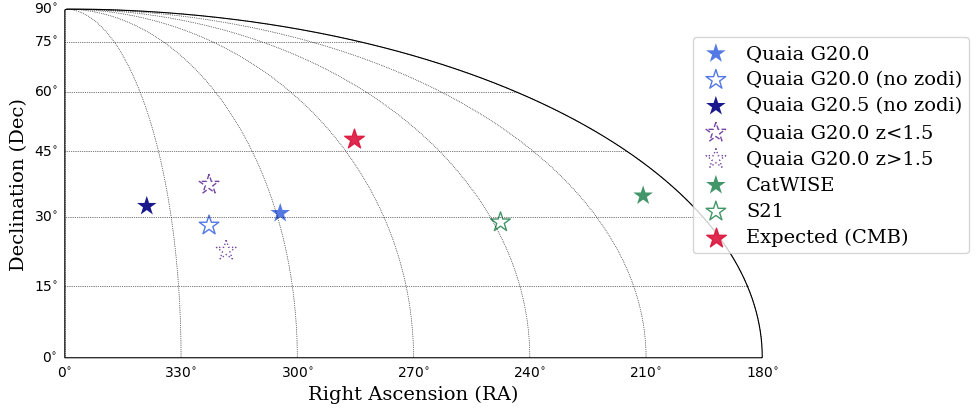

In [24]:
fig, ax = plt.subplots(figsize=(9,6))
sp = skyproj.MollweideSkyproj(ax=ax, extent=[180, 360, 0, 90])
sp.ax.tick_params(fontsize=16)
kwargs = dict(marker='*', s=220, alpha=0.9)

cs = ['royalblue', 'None', 'navy', 'None', 'None', 'seagreen', 'None']
edgecolors = ['None', cs[0], 'None', 'rebeccapurple', 'rebeccapurple', 'None', cs[-2]]
lss = ['-', '-', '-', '--', ':', '-', '-']
for i, (c, ec, ls, dipdir, dipamp, key) in enumerate(zip(cs, edgecolors, lss, standard_res['dipdirs'].values(),
                                                     standard_res['dipamps'].values(), labels.keys())):
    sp.scatter(dipdir.galactic.l.deg, dipdir.galactic.b.deg, color=c, label=labels[key], edgecolors=ec, ls=ls, **kwargs)

sp.scatter(cmb_dipdir.galactic.l.deg, cmb_dipdir.galactic.b.deg, color='crimson', 
        label=f'Expected (CMB)', **kwargs)#{"Expected:":<28}'r'$|\vec{\mathcal{D}_k}|=$'f'{cmb_dipamp:.4f}', **kwargs)
sp.legend(loc=(0.9, 0.3), fontsize=12)
sp.ax.set_xlabel('Right Ascension (RA)', fontsize=14)
sp.ax.set_ylabel('Declination (Dec)', fontsize=14)
sp.ax.tick_params(fontsize=12)
sp.ax.gridlines.set_alpha(0.4)

for text in sp.ax.findobj(): # match=plt.Text
    try:
        text.set_fontsize(14)
    except AttributeError:
        continue

## ABC results

In [25]:
resdir = '/scratch/aew492/lss-dipoles_results/results'
nside = 2

### `dipole_amp` as only free parameter

In [26]:
def get_abc_results_dipole_only(fn, xticks=None, title=None):

    res = np.load(fn, allow_pickle=True).item()
    history = res['history']
    prior = res['prior']
    posterior = res['posterior']
    selfunc = res['selfunc']
    expected_dipamp = res['expected_dipole_amp']
    print(f"expected dipole_amp = {expected_dipamp}")
    
    # quantiles
    df, w = posterior
    q_dipamp = tools.quantile(df['dipole_amp'], [0.16, 0.5, 0.84], weights=w)

    # calculate the sigma discrepancy: ****check with Kate and Hogg: is this the right way to do this?
    # z score is z = (x_0 - \mu) / \sigma , where x_0 is the null hypothesis, \mu is mean (or MAP? or median?)
    #    and \sigma = std. of the posterior
    
    # how different is the mean from the median?
    print(f"mean dipole_amp = {pyabc.weighted_statistics.weighted_mean(df['dipole_amp'], w):.4f}")
    print(f"median dipole_amp = {q_dipamp[1]:.4f}")
    mu = q_dipamp[1]
    
    # standard deviation
    sigma = pyabc.weighted_statistics.weighted_std(df['dipole_amp'], w)
    print(f"std dipole_amp = {sigma:.4f}")

    relamp = np.array(q_dipamp) / expected_dipamp
    
    # z score
    z = (expected_dipamp - mu) / sigma
    print(f"z score = {z:.4f}")

    # plot (copied and adjusted from the pyabc.visualization source code)
    par_id = [x for x in prior.keys()][0]
    fig, ax = plt.subplots(figsize=(5,4), tight_layout=True)
    label = 'Dipole amplitude in CMB dir.'
    
    df, w = posterior
    
    # quantiles?
    q = tools.quantile(df[par_id], [0.16, 0.5, 0.84], weights=w)
    
    # diagonal
    ax.axvline(q[1], c='k', alpha=0.4, ls='-', label='Median')
    ax.axvspan(q[0], q[2], color='k', alpha=0.05)
    ax.axhline(0., c='k', alpha=0.5, lw=0.5)
    ax.axvline(expected_dipamp, c='crimson', alpha=0.8, lw=1.5, label='Expected')
    ax.legend()
    ax.grid(alpha=0.5, lw=0.5)
    ax.set_xlim(prior[par_id].args[0], prior[par_id].args[0] + prior[par_id].args[1])
    if xticks is not None:
        ax.set_xticks(xticks)
    ax.axvline(0., c='k', alpha=0.5, lw=0.5)
    
    x, pdf = tools.get_kde_1d([df, w], prior, par_id)
    ax.plot(x, pdf, c='k', alpha=0.9, lw=1.5)
    
    ax.set_xlabel(label)

    if title is not None:
        ax.set_title(title)

    # update all font sizes in this ax
    for text in ax.findobj(match=plt.Text):
        text.set_fontsize(12)

    return q_dipamp, relamp, z, res, ax

In [32]:
abc_amp_res = {
    'quantiles' : {},
    'relamps' : {},
    'zscores' : {},
    'ress' : {}
}

#### Quaia G<20.0 with zodi

expected dipole_amp = 0.0052
mean dipole_amp = 0.0088
median dipole_amp = 0.0088
std dipole_amp = 0.0024
z score = -1.5129


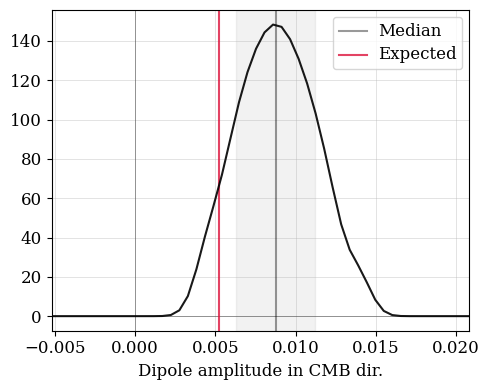

In [33]:
sample_name = 'quaia_G20.0_zodi'
q, relamp, z, res, ax = get_abc_results_dipole_only(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_only_nside{nside}_500mocks_18iters_base-rate-{base_rate_quaia:.4f}/results.npy'))
abc_amp_res['quantiles'][sample_name] = q
abc_amp_res['relamps'][sample_name] = relamp
abc_amp_res['zscores'][sample_name] = z
abc_amp_res['ress'][sample_name] = res

#### Quaia G<20.0 orig

expected dipole_amp = 0.0052
mean dipole_amp = 0.0100
median dipole_amp = 0.0101
std dipole_amp = 0.0029
z score = -1.7052


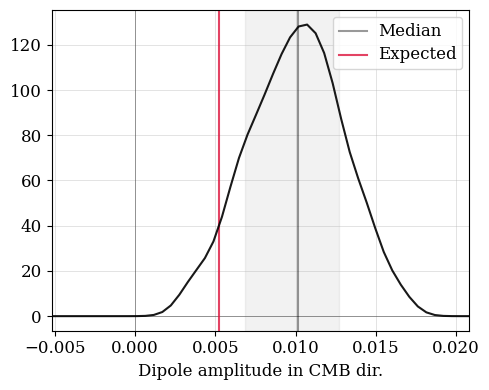

In [34]:
sample_name = 'quaia_G20.0_orig'
q, relamp, z, res, ax = get_abc_results_dipole_only(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_only_nside{nside}_500mocks_18iters_base-rate-{base_rate_quaia:.4f}/results.npy'))
abc_amp_res['quantiles'][sample_name] = q
abc_amp_res['relamps'][sample_name] = relamp
abc_amp_res['zscores'][sample_name] = z
abc_amp_res['ress'][sample_name] = res

#### Quaia G<20.5

expected dipole_amp = 0.0047
mean dipole_amp = 0.0126
median dipole_amp = 0.0125
std dipole_amp = 0.0025
z score = -3.1497


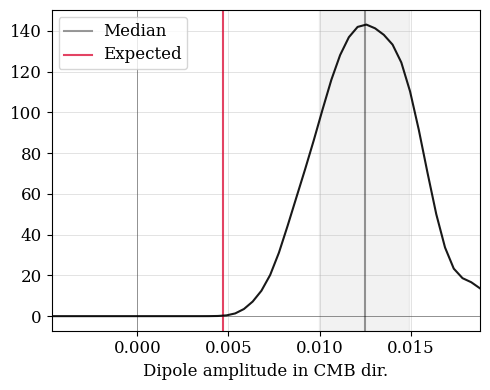

In [35]:
sample_name = 'quaia_G20.5_orig'
q, relamp, z, res, ax = get_abc_results_dipole_only(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_only_nside{nside}_500mocks_18iters_base-rate-{41.3560:.4f}/results.npy'))
abc_amp_res['quantiles'][sample_name] = q
abc_amp_res['relamps'][sample_name] = relamp
abc_amp_res['zscores'][sample_name] = z
abc_amp_res['ress'][sample_name] = res

#### Quaia G<20.0 zsplit2bin0

expected dipole_amp = 0.005
mean dipole_amp = 0.0105
median dipole_amp = 0.0110
std dipole_amp = 0.0030
z score = -1.9801


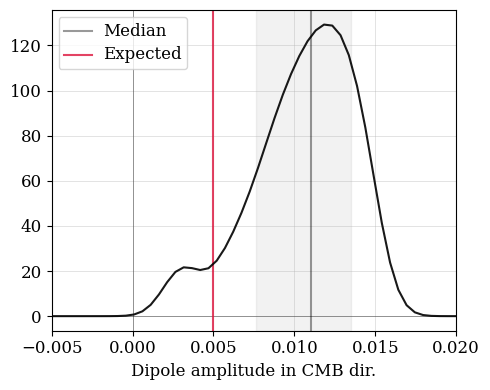

In [36]:
sample_name = 'quaia_G20.0_zsplit2bin0'
q, relamp, z, res, ax = get_abc_results_dipole_only(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_only_nside{nside}_500mocks_18iters_base-rate-{18.0810:.4f}/results.npy'))
abc_amp_res['quantiles'][sample_name] = q
abc_amp_res['relamps'][sample_name] = relamp
abc_amp_res['zscores'][sample_name] = z
abc_amp_res['ress'][sample_name] = res

#### Quaia G<20.0 zsplit2bin1

expected dipole_amp = 0.0055
mean dipole_amp = 0.0111
median dipole_amp = 0.0109
std dipole_amp = 0.0035
z score = -1.5508


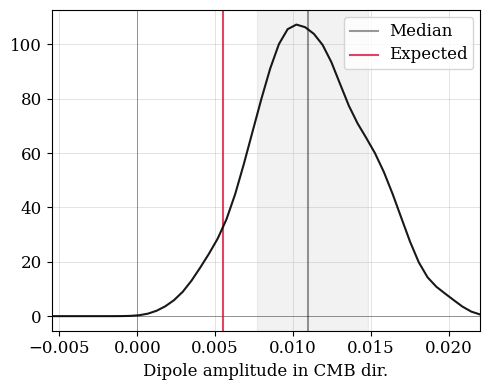

In [37]:
sample_name = 'quaia_G20.0_zsplit2bin1'
q, relamp, z, res, ax = get_abc_results_dipole_only(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_only_nside{nside}_500mocks_18iters_base-rate-{18.840:.4f}/results.npy'))
abc_amp_res['quantiles'][sample_name] = q
abc_amp_res['relamps'][sample_name] = relamp
abc_amp_res['zscores'][sample_name] = z
abc_amp_res['ress'][sample_name] = res

#### CatWISE with zodi

expected dipole_amp = 0.0074
mean dipole_amp = 0.0090
median dipole_amp = 0.0090
std dipole_amp = 0.0019
z score = -0.8677


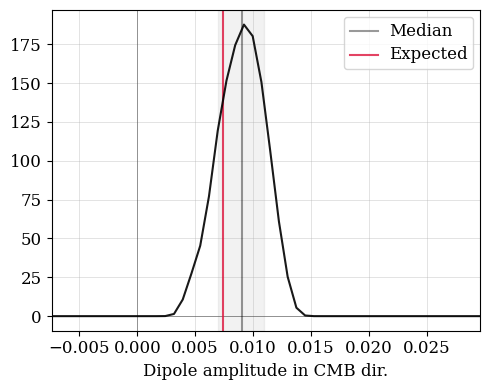

In [38]:
sample_name = 'catwise_zodi'
q, relamp, z, res, ax = get_abc_results_dipole_only(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_only_nside{nside}_500mocks_18iters_base-rate-{base_rate_catwise:.4f}/results.npy'))
abc_amp_res['quantiles'][sample_name] = q
abc_amp_res['relamps'][sample_name] = relamp
abc_amp_res['zscores'][sample_name] = z
abc_amp_res['ress'][sample_name] = res

#### CatWISE with elatcorr

expected dipole_amp = 0.0074
mean dipole_amp = 0.0120
median dipole_amp = 0.0120
std dipole_amp = 0.0019
z score = -2.4360


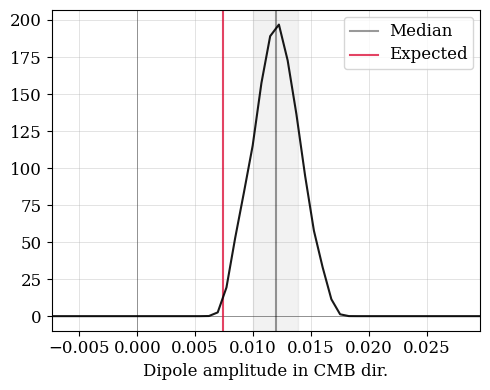

In [39]:
sample_name = 'catwise_elatcorr'
q, relamp, z, res, ax = get_abc_results_dipole_only(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_only_nside{nside}_500mocks_18iters_base-rate-{base_rate_catwise:.4f}/results.npy'))
abc_amp_res['quantiles'][sample_name] = q
abc_amp_res['relamps'][sample_name] = relamp
abc_amp_res['zscores'][sample_name] = z
abc_amp_res['ress'][sample_name] = res

In [40]:
print(f"{'sample name:':35}{'dipole posterior:':30}{'relative amplitude:':25}{'z score:'}")
print('=' * 110)
for i, (key, label) in enumerate(labels.items()):
    q, relamp, z = abc_amp_res['quantiles'][key], abc_amp_res['relamps'][key], abc_amp_res['zscores'][key]
    q_str = f'{q[1]:.4f} +{q[2]-q[1]:.4f} -{q[1]-q[0]:.4f}'
    relamp_str = f'{relamp[1]:.3f} +{relamp[2]-relamp[1]:.3f} -{relamp[1]-relamp[0]:.3f}'
    print(f"{label:35}{q_str:30}{relamp_str:25}{z:.3f}")

sample name:                       dipole posterior:             relative amplitude:      z score:
Quaia G20.0                        0.0088 +0.0024 -0.0025        1.690 +0.461 -0.479      -1.513
Quaia G20.0 (no zodi)              0.0101 +0.0026 -0.0032        1.947 +0.496 -0.625      -1.705
Quaia G20.5 (no zodi)              0.0125 +0.0024 -0.0025        2.660 +0.510 -0.540      -3.150
Quaia G20.0 z<1.5                  0.0110 +0.0025 -0.0034        2.203 +0.498 -0.681      -1.980
Quaia G20.0 z>1.5                  0.0109 +0.0039 -0.0033        1.988 +0.702 -0.595      -1.551
CatWISE                            0.0090 +0.0019 -0.0021        1.222 +0.256 -0.279      -0.868
S21                                0.0120 +0.0019 -0.0020        1.618 +0.262 -0.271      -2.436


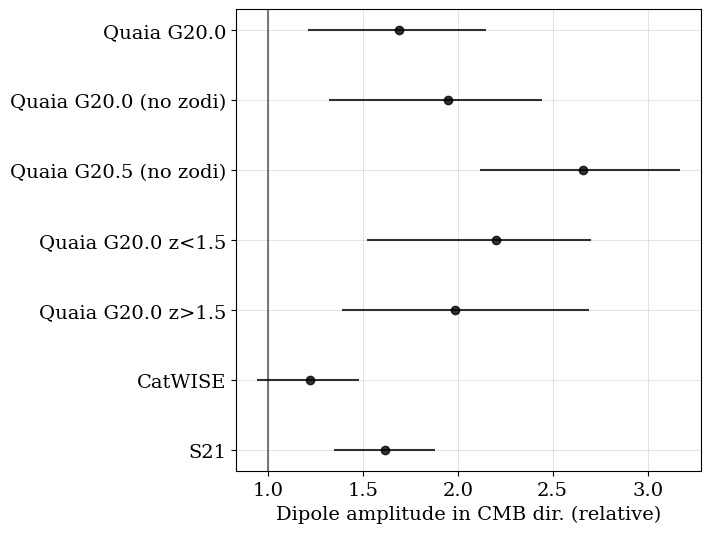

In [41]:
# summary plot
fig, ax = plt.subplots(figsize=(6,6))
cs = plt.get_cmap('tab10').colors

names = list(labels.values())
ylocs = np.arange(len(names))

ax.axvline(1., color='k', alpha=0.5)

for i, (key, label) in enumerate(labels.items()):
    relamp = abc_amp_res['relamps'][key]
    iname = names.index(label)
    err = np.array([relamp[1] - relamp[0], relamp[2] - relamp[1]])[:,np.newaxis]
        # error bars are the difference with the median rather than raw quantiles
    ax.errorbar(relamp[1], ylocs[-(iname+1)], xerr=err, marker='o', alpha=0.8, c='k')

ax.set_yticks(ylocs[::-1], names)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel('Dipole amplitude in CMB dir. (relative)')

# give the fiducial samples bold labels
new_labels = []
for label in ax.get_yticklabels():
    if label._text == 'quaia_G20.0_zodi' or label._text == 'catwise_zodi':
        label.set_fontweight('bold')
    new_labels.append(label)
ax.set_yticklabels(new_labels)

# update all font sizes in this ax
for text in ax.findobj(match=plt.Text):
    text.set_fontsize(14)

### `dipole_amp` and `log_excess`

In [42]:
def get_abc_results_dipole_excess(fn, xticks=None, title=None, SN=None):

    res = np.load(fn, allow_pickle=True).item()
    history = res['history']
    prior = res['prior']
    posterior = res['posterior']
    selfunc = res['selfunc']
    expected_dipamp = res['expected_dipole_amp']
    print(f"expected dipole_amp = {expected_dipamp}")
    
    # quantiles
    df, w = posterior
    q_dipamp = tools.quantile(df['dipole_amp'], [0.16, 0.5, 0.84], weights=w)
    q_excess = tools.quantile(df['log_excess'], [0.16, 0.5, 0.84], weights=w)

    # calculate the sigma discrepancy: ****check with Kate and Hogg: is this the right way to do this?
    # z score is z = (x_0 - \mu) / \sigma , where x_0 is the null hypothesis, \mu is mean (or MAP? or median?)
    #    and \sigma = std. of the posterior
    
    # how different is the mean from the median?
    print(f"mean dipole_amp = {pyabc.weighted_statistics.weighted_mean(df['dipole_amp'], w):.4f}")
    print(f"median dipole_amp = {q_dipamp[1]:.4f}")
    mu = q_dipamp[1]
    
    # standard deviation
    sigma = pyabc.weighted_statistics.weighted_std(df['dipole_amp'], w)
    print(f"std dipole_amp = {sigma:.4f}")

    relamp = np.array(q_dipamp) / expected_dipamp
    
    # z score
    z = (expected_dipamp - mu) / sigma
    print(f"z score = {z:.4f}")

    # plot (copied and adjusted from the pyabc.visualization source code)
    par_id = [x for x in prior.keys()][0]
    fig, axs = plt.subplots(2, 2, figsize=(7,6), tight_layout=True)
    
    df, w = posterior

    par_ids = [x for x in prior.keys()]
    labels = [r'$\vec{\mathcal{D}}\cdot\hat n_\mathrm{CMB}$', r'$\log \bar C$']  # bug: these labels are hard-coded

    for i, par_id in enumerate(par_ids):
    
        # quantiles?
        q = tools.quantile(df[par_id], [0.16, 0.5, 0.84], weights=w)
        
        # diagonal
        ax = axs[i, i]
        ax.axvline(q[1], c='k', alpha=0.4, ls='-', label='Median')
        ax.axvspan(q[0], q[2], color='k', alpha=0.05)
        ax.axhline(0., c='k', alpha=0.5, lw=0.5)
        if i == 0:
            ax.axvline(expected_dipamp, c='crimson', alpha=0.8, lw=1.5, label='Expected')
        if i == 1 and SN is not None:
            ax.axvline(np.log10(SN), c='b', alpha=0.4, lw=1.5, label='SN')
        ax.legend()
        ax.grid(alpha=0.5, lw=0.5)
        ax.set_xlim(prior[par_id].args[0], prior[par_id].args[0] + prior[par_id].args[1])
        if xticks is not None:
            ax.set_xticks(xticks)
        ax.axvline(0., c='k', alpha=0.5, lw=0.5)
        
        x, pdf = tools.get_kde_1d([df, w], prior, par_id)
        ax.plot(x, pdf, c='k', alpha=0.9, lw=1.5)

        axs[i,0].set_ylabel(labels[i], fontsize=13)
        axs[len(par_ids)-1,i].set_xlabel(labels[i], fontsize=13)

        for j in range(0, i):
    
            # lower
            ax = axs[i, j]
            x, y, pdf = tools.get_kde_2d([df, w], prior, par_ids[j], par_id)
            mesh = ax.pcolormesh(x, y, pdf, shading='auto', cmap='binary')
    
            # upper
            ax = axs[j, i]
            tools.scatter([df, w], prior, par_id, par_ids[j], ax, color='k', alpha=0.5, marker='.', s=3)
            ax.grid(alpha=0.5, lw=0.5)
    
    if title is not None:
        fig.suptitle(title)
    
    return q_dipamp, q_excess, relamp, z, axs

In [43]:
abc_amp_excess_res = {
    'quantiles_amp' : {},
    'quantiles_excess' : {},
    'relamps' : {},
    'zscores' : {},
    'ress' : {}
}

#### Quaia G<20.0 with zodi

expected dipole_amp = 0.0052
mean dipole_amp = 0.0088
median dipole_amp = 0.0087
std dipole_amp = 0.0026
z score = -1.3762


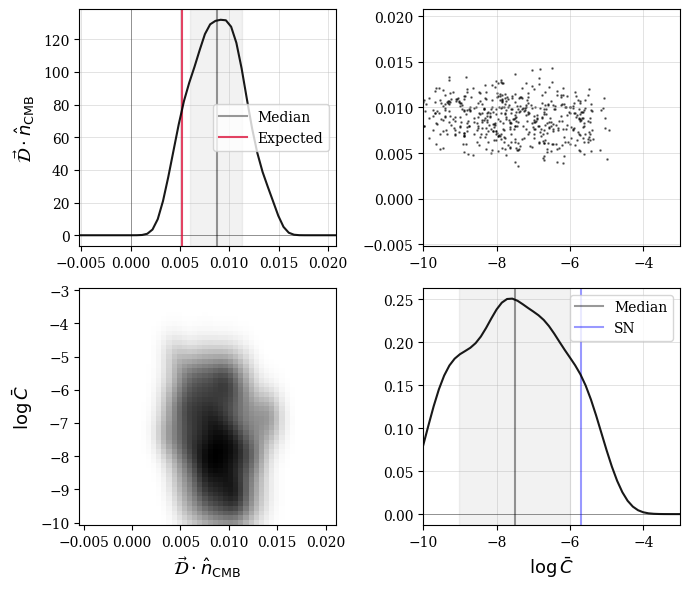

In [44]:
sample_name = 'quaia_G20.0_zodi'
q_amp, q_excess, relamp, z, axs = get_abc_results_dipole_excess(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{base_rate_quaia:.4f}/results.npy'),
                                                          SN=1/Nsources[sample_name])
abc_amp_excess_res['quantiles_amp'][sample_name] = q_amp
abc_amp_excess_res['quantiles_excess'][sample_name] = q_excess
abc_amp_excess_res['relamps'][sample_name] = relamp
abc_amp_excess_res['zscores'][sample_name] = z
abc_amp_excess_res['ress'][sample_name] = res

#### Quaia G<20.0 orig

expected dipole_amp = 0.0052
mean dipole_amp = 0.0097
median dipole_amp = 0.0095
std dipole_amp = 0.0025
z score = -1.7041


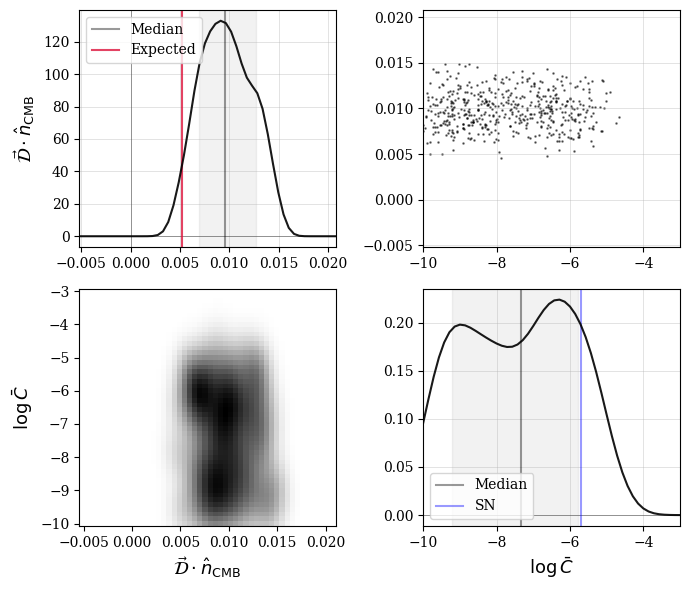

In [45]:
sample_name = 'quaia_G20.0_orig'
q_amp, q_excess, relamp, z, axs = get_abc_results_dipole_excess(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{base_rate_quaia:.4f}/results.npy'),
                                                          SN=1/Nsources[sample_name])
abc_amp_excess_res['quantiles_amp'][sample_name] = q_amp
abc_amp_excess_res['quantiles_excess'][sample_name] = q_excess
abc_amp_excess_res['relamps'][sample_name] = relamp
abc_amp_excess_res['zscores'][sample_name] = z
abc_amp_excess_res['ress'][sample_name] = res

#### Quaia G<20.5

expected dipole_amp = 0.0047
mean dipole_amp = 0.0127
median dipole_amp = 0.0127
std dipole_amp = 0.0026
z score = -3.0662


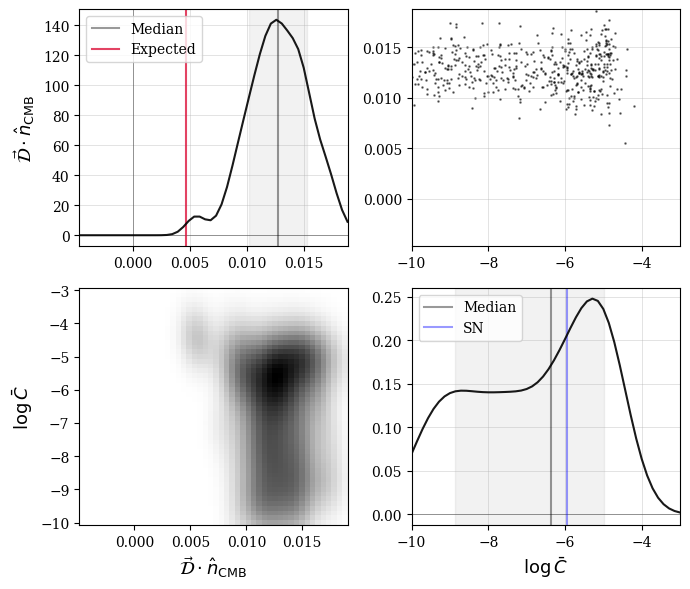

In [46]:
sample_name = 'quaia_G20.5_orig'
q_amp, q_excess, relamp, z, axs = get_abc_results_dipole_excess(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{41.3560:.4f}/results.npy'),
                                                               SN=1/Nsources[sample_name])
abc_amp_excess_res['quantiles_amp'][sample_name] = q_amp
abc_amp_excess_res['quantiles_excess'][sample_name] = q_excess
abc_amp_excess_res['relamps'][sample_name] = relamp
abc_amp_excess_res['zscores'][sample_name] = z
abc_amp_excess_res['ress'][sample_name] = res

#### Quaia G<20.0 zsplit2bin0

expected dipole_amp = 0.005
mean dipole_amp = 0.0124
median dipole_amp = 0.0124
std dipole_amp = 0.0033
z score = -2.2212


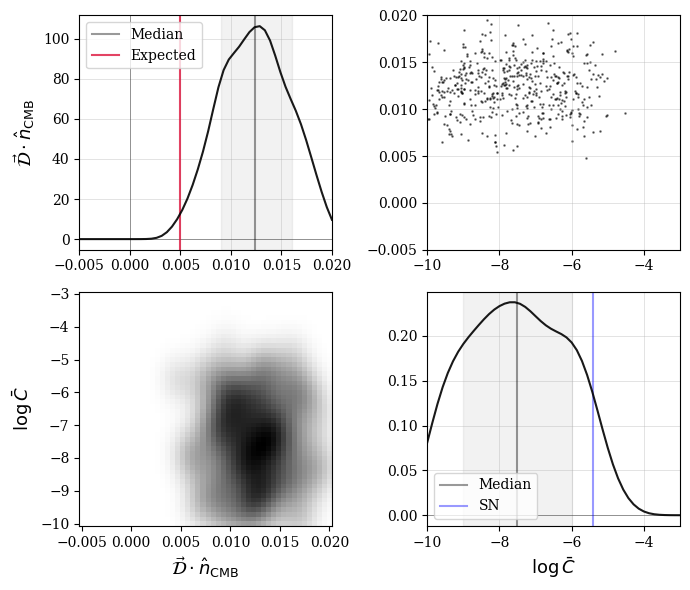

In [47]:
sample_name = 'quaia_G20.0_zsplit2bin0'
q_amp, q_excess, relamp, z, axs = get_abc_results_dipole_excess(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{18.0810:.4f}/results.npy'),
                                                               SN=1/Nsources[sample_name])
abc_amp_excess_res['quantiles_amp'][sample_name] = q_amp
abc_amp_excess_res['quantiles_excess'][sample_name] = q_excess
abc_amp_excess_res['relamps'][sample_name] = relamp
abc_amp_excess_res['zscores'][sample_name] = z
abc_amp_excess_res['ress'][sample_name] = res

#### Quaia G<20.0 zsplit2bin1

expected dipole_amp = 0.0055
mean dipole_amp = 0.0111
median dipole_amp = 0.0111
std dipole_amp = 0.0038
z score = -1.4891


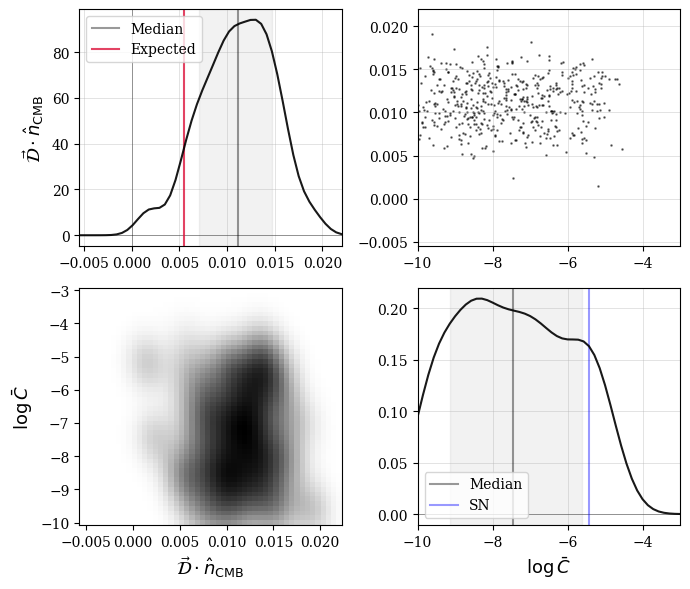

In [48]:
sample_name = 'quaia_G20.0_zsplit2bin1'
q_amp, q_excess, relamp, z, axs = get_abc_results_dipole_excess(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{18.840:.4f}/results.npy'),
                                                               SN=1/Nsources[sample_name])
abc_amp_excess_res['quantiles_amp'][sample_name] = q_amp
abc_amp_excess_res['quantiles_excess'][sample_name] = q_excess
abc_amp_excess_res['relamps'][sample_name] = relamp
abc_amp_excess_res['zscores'][sample_name] = z
abc_amp_excess_res['ress'][sample_name] = res

### CatWISE with zodi

expected dipole_amp = 0.0074
mean dipole_amp = 0.0090
median dipole_amp = 0.0091
std dipole_amp = 0.0022
z score = -0.7775


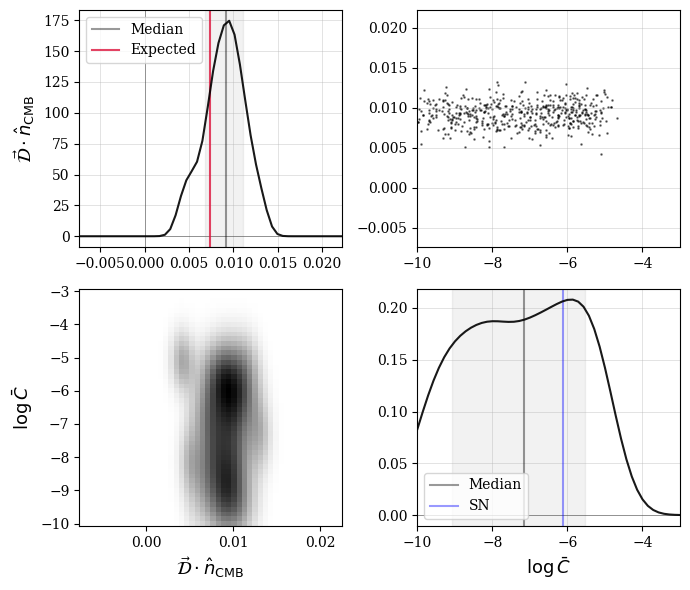

In [49]:
sample_name = 'catwise_zodi'
q_amp, q_excess, relamp, z, axs = get_abc_results_dipole_excess(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{base_rate_catwise:.4f}/results.npy'),
                                                               SN=1/Nsources[sample_name])
abc_amp_excess_res['quantiles_amp'][sample_name] = q_amp
abc_amp_excess_res['quantiles_excess'][sample_name] = q_excess
abc_amp_excess_res['relamps'][sample_name] = relamp
abc_amp_excess_res['zscores'][sample_name] = z
abc_amp_excess_res['ress'][sample_name] = res

#### CatWISE elatcorr

expected dipole_amp = 0.0074
mean dipole_amp = 0.0122
median dipole_amp = 0.0121
std dipole_amp = 0.0020
z score = -2.3245


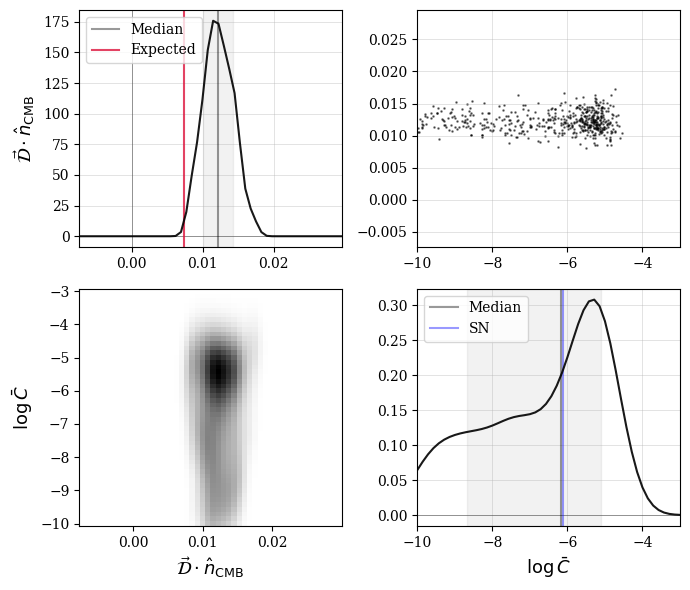

In [50]:
sample_name = 'catwise_elatcorr'
q_amp, q_excess, relamp, z, axs = get_abc_results_dipole_excess(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{base_rate_catwise:.4f}/results.npy'),
                                                               SN=1/Nsources[sample_name])
abc_amp_excess_res['quantiles_amp'][sample_name] = q_amp
abc_amp_excess_res['quantiles_excess'][sample_name] = q_excess
abc_amp_excess_res['relamps'][sample_name] = relamp
abc_amp_excess_res['zscores'][sample_name] = z
abc_amp_excess_res['ress'][sample_name] = res

In [51]:
print(f"{'sample name:':35}{'dipole posterior:':30}{'log excess posterior:':30}{'relative amplitude:':25}{'z score:'}")
print('=' * 130)
for i, (key, label) in enumerate(labels.items()):
    strs = [
        f'{x[1]:.4f} +{x[2]-x[1]:.4f} -{x[1]-x[0]:.4f}' for x in [abc_amp_excess_res['quantiles_amp'][key],
                                                                  abc_amp_excess_res['quantiles_excess'][key],
                                                                  abc_amp_excess_res['relamps'][key]]
    ]
    print(f"{label:35}{strs[0]:30}{strs[1]:30}{strs[2]:25}{abc_amp_excess_res['zscores'][key]:.3f}")

sample name:                       dipole posterior:             log excess posterior:         relative amplitude:      z score:
Quaia G20.0                        0.0087 +0.0025 -0.0028        -7.4939 +1.4990 -1.5232       1.6821 +0.4877 -0.5297   -1.376
Quaia G20.0 (no zodi)              0.0095 +0.0032 -0.0026        -7.3378 +1.5628 -1.8639       1.8337 +0.6189 -0.5022   -1.704
Quaia G20.5 (no zodi)              0.0127 +0.0025 -0.0026        -6.3750 +1.3935 -2.5054       2.7109 +0.5316 -0.5455   -3.066
Quaia G20.0 z<1.5                  0.0124 +0.0036 -0.0034        -7.5222 +1.5288 -1.4980       2.4702 +0.7299 -0.6730   -2.221
Quaia G20.0 z>1.5                  0.0111 +0.0035 -0.0041        -7.4621 +1.8499 -1.6778       2.0240 +0.6430 -0.7371   -1.489
CatWISE                            0.0091 +0.0020 -0.0023        -7.1543 +1.6295 -1.9109       1.2306 +0.2708 -0.3098   -0.778
S21                                0.0121 +0.0022 -0.0020        -6.1801 +1.0730 -2.4985       1.6413 +0.2944

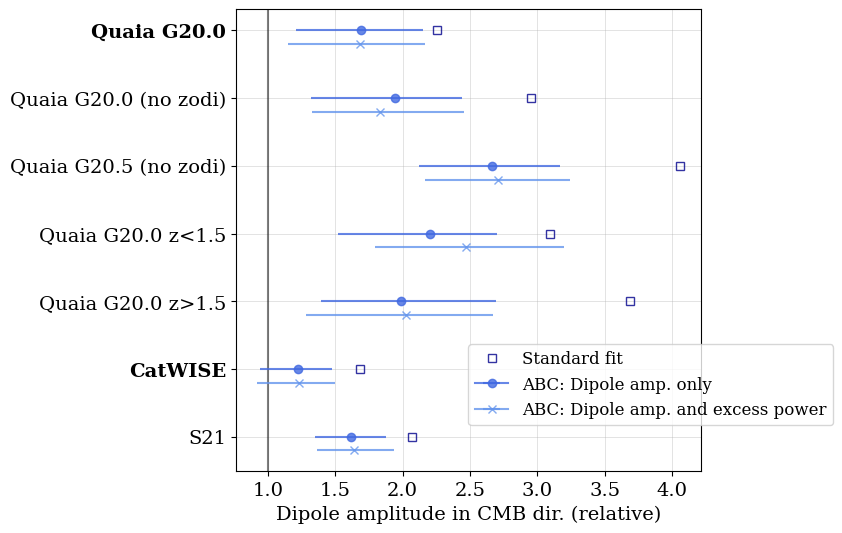

In [52]:
# summary plot
fig, ax = plt.subplots(figsize=(6,6))
cs = plt.get_cmap('tab10').colors

names = list(labels.values())
ylocs = np.arange(len(names))

ax.axvline(1., color='k', alpha=0.5)

for i, (key, label) in enumerate(labels.items()):
    legend_labels = ['ABC: Dipole amp. only', 'ABC: Dipole amp. and excess power', 'Standard fit'] if i == 0 else [None, None, None]
    iname = names.index(label)
    relamp_standard = standard_res['relamps'][key]
    relamp_amp = abc_amp_res['relamps'][key]
    relamp_amp_excess = abc_amp_excess_res['relamps'][key]
    err_amp = np.array([relamp_amp[1] - relamp_amp[0], relamp_amp[2] - relamp_amp[1]])[:,np.newaxis]
        # error bars are the difference with the median rather than raw quantiles
    err_amp_excess = np.array([relamp_amp_excess[1] - relamp_amp_excess[0], relamp_amp_excess[2] - relamp_amp_excess[1]])[:,np.newaxis]
    ax.errorbar(relamp_amp[1], ylocs[-(iname+1)], xerr=err_amp, marker='o', alpha=0.8, c='royalblue', label=legend_labels[0])
    ax.errorbar(relamp_amp_excess[1], ylocs[-(iname+1)] - 0.2, xerr=err_amp_excess, marker='x', alpha=0.8, c='cornflowerblue',
               label=legend_labels[1])
    ax.plot(relamp_standard, ylocs[-(iname+1)], marker='s', alpha=0.8, c='None', mec='darkblue', label=legend_labels[2])

ax.set_yticks(ylocs[::-1], names)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel('Dipole amplitude in CMB dir. (relative)')

# give the fiducial samples bold labels
new_labels = []
for label in ax.get_yticklabels():
    if label._text == 'Quaia G20.0' or label._text == 'CatWISE':
        label.set_fontweight('bold')
    new_labels.append(label)
ax.set_yticklabels(new_labels)

# update all font sizes in this ax
for text in ax.findobj(match=plt.Text):
    text.set_fontsize(14)

ax.legend(loc=(0.5, 0.1), fontsize=12)

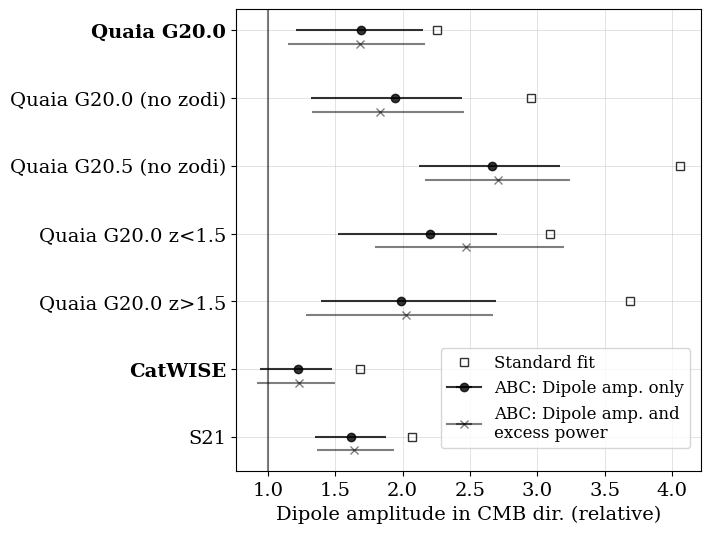

In [58]:
# summary plot
fig, ax = plt.subplots(figsize=(6,6))
cs = plt.get_cmap('tab10').colors

names = list(labels.values())
ylocs = np.arange(len(names))

ax.axvline(1., color='k', alpha=0.5)

for i, (key, label) in enumerate(labels.items()):
    legend_labels = ['ABC: Dipole amp. only', f'ABC: Dipole amp. and\nexcess power', 'Standard fit'] if i == 0 else [None, None, None]
    iname = names.index(label)
    relamp_standard = standard_res['relamps'][key]
    relamp_amp = abc_amp_res['relamps'][key]
    relamp_amp_excess = abc_amp_excess_res['relamps'][key]
    err_amp = np.array([relamp_amp[1] - relamp_amp[0], relamp_amp[2] - relamp_amp[1]])[:,np.newaxis]
        # error bars are the difference with the median rather than raw quantiles
    err_amp_excess = np.array([relamp_amp_excess[1] - relamp_amp_excess[0], relamp_amp_excess[2] - relamp_amp_excess[1]])[:,np.newaxis]
    ax.errorbar(relamp_amp[1], ylocs[-(iname+1)], xerr=err_amp, marker='o', alpha=0.8, c='k', label=legend_labels[0])
    ax.errorbar(relamp_amp_excess[1], ylocs[-(iname+1)] - 0.2, xerr=err_amp_excess, marker='x', alpha=0.5, c='k',
               label=legend_labels[1])
    ax.plot(relamp_standard, ylocs[-(iname+1)], marker='s', alpha=0.8, c='None', mec='k', label=legend_labels[2])

ax.set_yticks(ylocs[::-1], names)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel('Dipole amplitude in CMB dir. (relative)')

# give the fiducial samples bold labels
new_labels = []
for label in ax.get_yticklabels():
    if label._text == 'Quaia G20.0' or label._text == 'CatWISE':
        label.set_fontweight('bold')
    new_labels.append(label)
ax.set_yticklabels(new_labels)

# update all font sizes in this ax
for text in ax.findobj(match=plt.Text):
    text.set_fontsize(14)

ax.legend(loc=(0.44, 0.05), fontsize=12)

## free dipole

In [27]:
def get_abc_results_free_dipole(fn, xticks=None, title=None):

    res = np.load(fn, allow_pickle=True).item()
    history = res['history']
    prior = res['prior']
    posterior = res['posterior']
    selfunc = res['selfunc']
    expected_dipamp = res['expected_dipole_amp']

    par_ids = [x for x in prior.keys()]
    fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(10,8), tight_layout=True)
    labels = [r'$\mathcal{D}_x$', r'$\mathcal{D}_y$', r'$\mathcal{D}_z$']  # bug: these labels are hard-coded

    df, w = posterior

    # quantiles
    qs = [
        tools.quantile(df[par_id], [0.16, 0.5, 0.84], weights=w) for par_id in ['dipole_x', 'dipole_y', 'dipole_z']
    ]

    for i, par_id in enumerate(par_ids):

        # quantile
        q = qs[i]
        
        # diagonal
        ax = axs[i, i]
        ax.axvline(q[1], c='k', alpha=0.4, ls='-', label='Median')
        ax.axvspan(q[0], q[2], color='k', alpha=0.05)
        ax.axhline(0., c='k', alpha=0.5, lw=0.5)
        ax.grid(alpha=0.5, lw=0.5)
        ax.set_xlim(prior[par_id].args[0], prior[par_id].args[0] + prior[par_id].args[1])
        if xticks is not None:
            ax.set_xticks(xticks)
        ax.axvline(0., c='k', alpha=0.5, lw=0.5)
        
        x, pdf = tools.get_kde_1d([df, w], prior, par_id)
        ax.plot(x, pdf, c='k', alpha=0.9, lw=1.5)

        axs[i,0].set_ylabel(labels[i], fontsize=12)
        axs[len(par_ids)-1,i].set_xlabel(labels[i], fontsize=12)

        for j in range(0, i):
    
            # lower
            ax = axs[i, j]
            x, y, pdf = tools.get_kde_2d([df, w], prior, par_ids[j], par_id)
            mesh = ax.pcolormesh(x, y, pdf, shading='auto', cmap='binary')
    
            # upper
            ax = axs[j, i]
            tools.scatter([df, w], prior, par_id, par_ids[j], ax, color='k', alpha=0.5, marker='.', s=3)
            ax.grid(alpha=0.5, lw=0.5)
        
    if title is not None:
        fig.suptitle(title)

    return qs, res, axs

In [28]:
# where to store results
free_dip_res = {
    'comps' : {}
}

#### Quaia G20.0 zodi

(0.011298949238803972, <SkyCoord (ICRS): (ra, dec) in deg
    (186.71921328, -28.66773712)>)


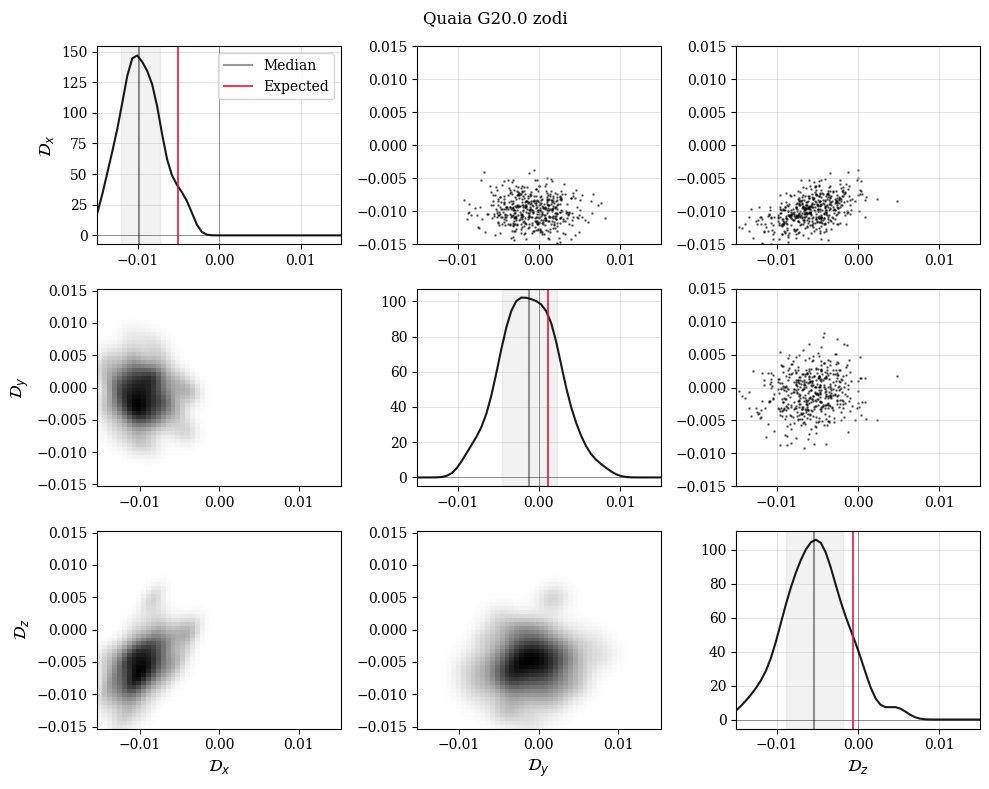

In [29]:
sample_name = 'quaia_G20.0_zodi'
qs, res, axs = get_abc_results_free_dipole(os.path.join(resdir,
                            f'ABC/{sample_name}_free_dipole_nside{nside}_500mocks_18iters_base-rate-{base_rate_quaia:.4f}/results.npy'),
                                          title='Quaia G20.0 zodi')
# expected dipole
expected_dipamp = 0.0052
expected_dipdir = SkyCoord(264, 48, unit=u.deg, frame='galactic')
comps = tools.spherical_to_cartesian(r=expected_dipamp, theta=np.pi/2-expected_dipdir.icrs.dec.rad, phi=expected_dipdir.icrs.ra.rad)
for i, comp in enumerate(comps):
    axs[i,i].axvline(comp, c='crimson', alpha=0.8, lw=1.5, label='Expected')
axs[0,0].legend()

# recovered dipole components
comps = np.array([q[1] for q in qs])  # pick out the medians from the quantiles
free_dip_res['comps'][sample_name] = comps
print(dipole.get_dipole(comps))

#### CatWISE zodi

(0.013594849167735606, <SkyCoord (ICRS): (ra, dec) in deg
    (127.54446357, 28.05525408)>)


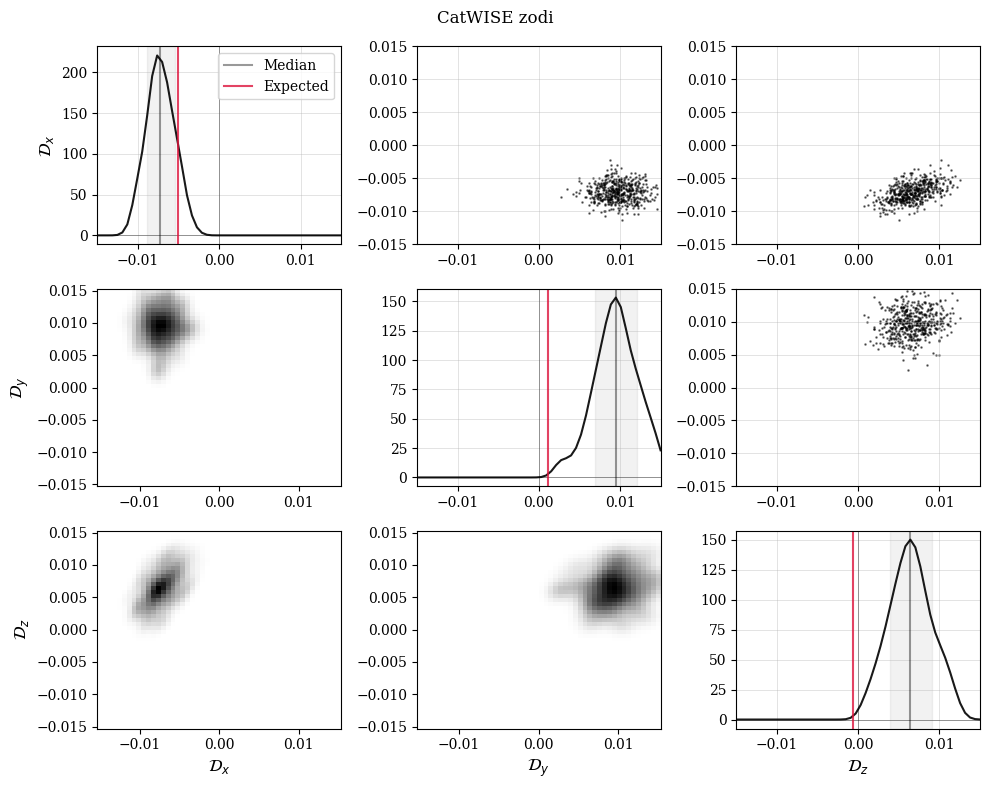

In [30]:
sample_name = 'catwise_zodi'
qs, res, axs = get_abc_results_free_dipole(os.path.join(resdir,
                            f'ABC/{sample_name}_free_dipole_nside{nside}_500mocks_18iters_base-rate-{base_rate_catwise:.4f}/results.npy'),
                                          title='CatWISE zodi')
# expected dipole
expected_dipamp = 0.0052
expected_dipdir = SkyCoord(264, 48, unit=u.deg, frame='galactic')
comps = tools.spherical_to_cartesian(r=expected_dipamp, theta=np.pi/2-expected_dipdir.icrs.dec.rad, phi=expected_dipdir.icrs.ra.rad)
for i, comp in enumerate(comps):
    axs[i,i].axvline(comp, c='crimson', alpha=0.8, lw=1.5, label='Expected')
axs[0,0].legend()

# recovered dipole components
comps = np.array([q[1] for q in qs])  # pick out the medians from the quantiles
free_dip_res['comps'][sample_name] = comps
print(dipole.get_dipole(comps))

#### CatWISE elatcorr

(0.015528106865091058, <SkyCoord (ICRS): (ra, dec) in deg
    (140.88628986, -7.23114046)>)


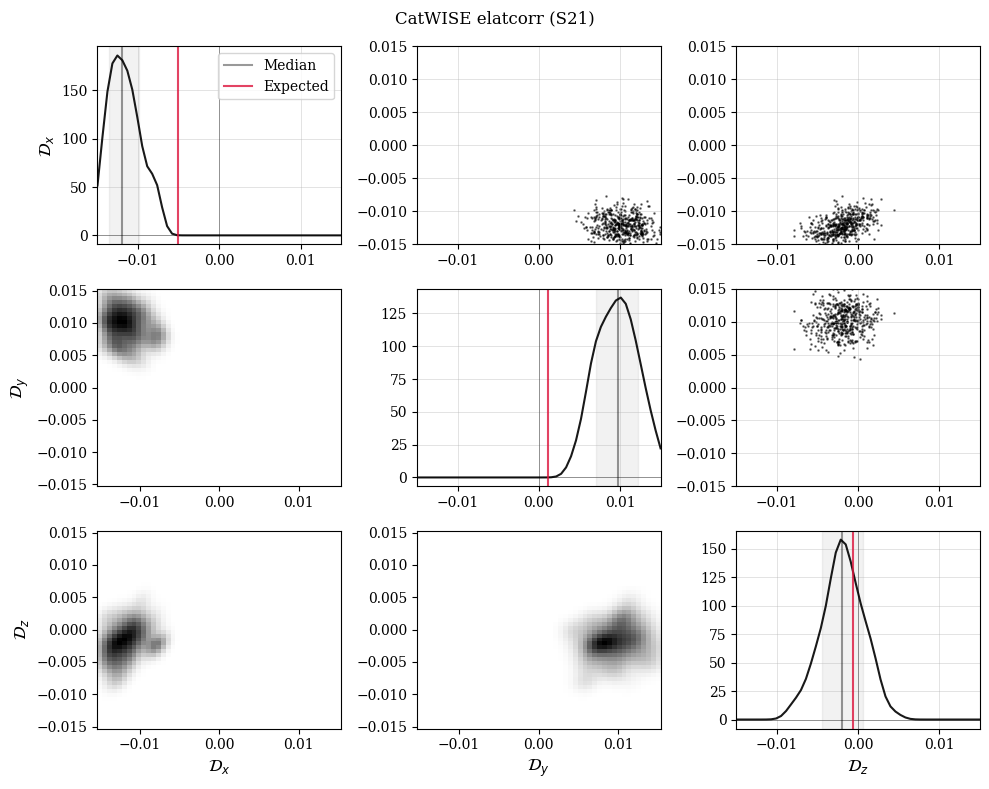

In [31]:
sample_name = 'catwise_elatcorr'
qs, res, axs = get_abc_results_free_dipole(os.path.join(resdir,
                            f'ABC/{sample_name}_free_dipole_nside{nside}_500mocks_18iters_base-rate-{base_rate_catwise:.4f}/results.npy'),
                                          title='CatWISE elatcorr (S21)')
# expected dipole
expected_dipamp = 0.0052
expected_dipdir = SkyCoord(264, 48, unit=u.deg, frame='galactic')
comps = tools.spherical_to_cartesian(r=expected_dipamp, theta=np.pi/2-expected_dipdir.icrs.dec.rad, phi=expected_dipdir.icrs.ra.rad)
for i, comp in enumerate(comps):
    axs[i,i].axvline(comp, c='crimson', alpha=0.8, lw=1.5, label='Expected')
axs[0,0].legend()

# recovered dipole components
comps = np.array([q[1] for q in qs])  # pick out the medians from the quantiles
free_dip_res['comps'][sample_name] = comps
print(dipole.get_dipole(comps))

In [32]:
# out of curiosity, do the projections of the measured dipoles match the inference with fixed kinematic dipole direction?

# back out the dipole 3-vector from the expected amplitude and CMB dipole direction
expected_comps = {}
expected_comps['quaia_G20.0_zodi'] = dipole.cmb_dipole(amplitude=quaia_expected_dipamp, return_comps=True)
expected_comps['catwise_zodi'] = dipole.cmb_dipole(amplitude=catwise_expected_dipamp, return_comps=True)
expected_comps['catwise_elatcorr'] = dipole.cmb_dipole(amplitude=catwise_expected_dipamp, return_comps=True)

free_dip_proj = {}
for key in labels.keys():
    if key in free_dip_res['comps'].keys():
        # projection of the total dipole onto the CMB dipole direction
        free_dip_proj[key] = (np.dot(expected_comps[key], free_dip_res['comps'][key]) / \
                                 np.linalg.norm(expected_comps[key])**2) * expected_comps[key]

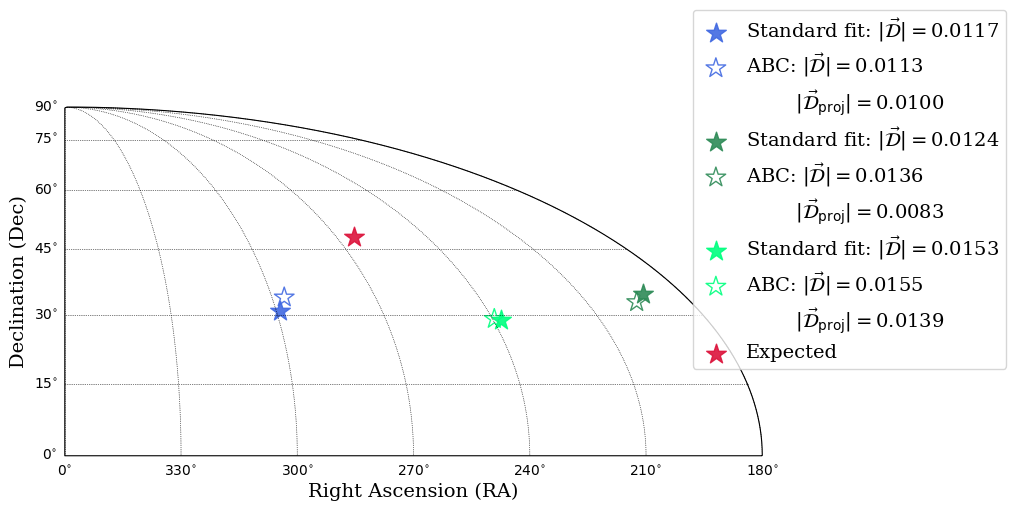

In [35]:
fig, ax = plt.subplots(figsize=(9,6))
sp = skyproj.MollweideSkyproj(ax=ax, extent=[180, 360, 0, 90])
sp.ax.tick_params(fontsize=16)
kwargs = dict(marker='*', s=220, alpha=0.9)

cs = ['royalblue', 'None', 'navy', 'None', 'None', 'seagreen', 'springgreen']
for i, (c, standard_dipdir, standard_dipamp, key) in enumerate(zip(cs, standard_res['dipdirs'].values(),
                                                     standard_res['dipamps'].values(), labels.keys())):
    if key in free_dip_res['comps']:
        sp.scatter(standard_dipdir.galactic.l.deg, standard_dipdir.galactic.b.deg, color=c,
                                            label=r'Standard fit: $|\vec{\mathcal{D}}|=$'f'{standard_res["dipamps"][key]:.4f}', **kwargs)
        # get the ABC free dipole results
        free_dipamp, free_dipdir = dipole.get_dipole(free_dip_res['comps'][key])
        sp.scatter(free_dipdir.galactic.l.deg, free_dipdir.galactic.b.deg, color='None', edgecolors=c,
                                                   label=r'ABC: $|\vec{\mathcal{D}}|=$'f'{free_dipamp:.4f}', **kwargs)
        # plot the projection
        free_proj_dipamp, free_proj_dipdir = dipole.get_dipole(free_dip_proj[key])
        sp.scatter(free_proj_dipdir.galactic.l.deg, free_proj_dipdir.galactic.b.deg, color=c,
                                                   label=f'\t'r'$|\vec{\mathcal{D}}_\mathrm{proj}|=$'f'{free_proj_dipamp:.4f}', marker='None', s=200)

sp.scatter(cmb_dipdir.galactic.l.deg, cmb_dipdir.galactic.b.deg, color='crimson', 
        label=f'Expected', **kwargs)#{"Expected:":<28}'r'$|\vec{\mathcal{D}_k}|=$'f'{cmb_dipamp:.4f}', **kwargs)
sp.legend(loc=(0.9, 0.25), fontsize=12)
sp.ax.set_xlabel('Right Ascension (RA)', fontsize=14)
sp.ax.set_ylabel('Declination (Dec)', fontsize=14)
sp.ax.tick_params(fontsize=12)
sp.ax.gridlines.set_alpha(0.4)

for text in sp.ax.findobj(): # match=plt.Text
    try:
        text.set_fontsize(14)
    except AttributeError:
        continue